In [1]:
import opentrons.simulate as simulate
from opentrons.protocols import bundle
import io
import sys

import os
import tempfile
import sbol3
import labop
import tyto
import uml
import json
import rdflib as rdfl
from IPython.display import Markdown, IFrame
# %matplotlib inline
from IPython.display import Image

from labop.execution_engine import ExecutionEngine
# from labop_check.labop_check import check_doc
from labop_convert.markdown.markdown_specialization import MarkdownSpecialization
from labop_convert.opentrons.opentrons_specialization import OT2Specialization
from labop.utils.opentrons import run_ot2_sim, make_demo_script

out_dir = os.path.join(os.path.abspath(""), "out")
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

%load_ext autoreload
%autoreload 2

/Users/jeytse/BMEY3_LabAutomationGroupProject/labOP_env/lib/python3.10/site-packages/sbol3/object.py:70: UserWarning: Using a default namespace. To set a namespace use set_namespace()
  warnings.warn('Using a default namespace.'


Setting up document
Importing libraries
... Imported liquid handling
... Imported plate handling
... Imported spectrophotometry
... Imported sample arrays


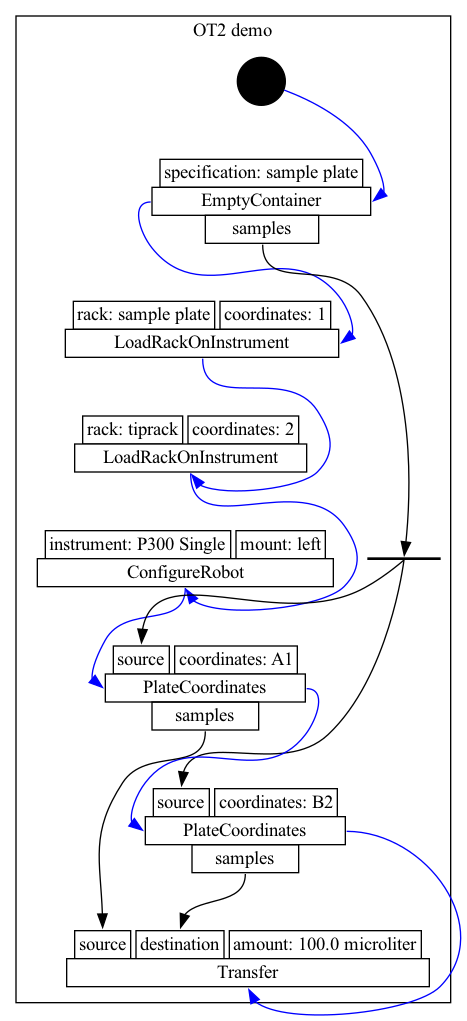

In [2]:
#############################################
# set up the document
print('Setting up document')
doc = sbol3.Document()
sbol3.set_namespace('https://bbn.com/scratch/')

#############################################
# Import the primitive libraries
print('Importing libraries')
labop.import_library('liquid_handling')
print('... Imported liquid handling')
labop.import_library('plate_handling')
print('... Imported plate handling')
labop.import_library('spectrophotometry')
print('... Imported spectrophotometry')
labop.import_library('sample_arrays')
print('... Imported sample arrays')

protocol = labop.Protocol("OT2_demo")
protocol.name = "OT2 demo"
doc.add(protocol)

CONT_NS = rdfl.Namespace('https://sift.net/container-ontology/container-ontology#')
OM_NS = rdfl.Namespace('http://www.ontology-of-units-of-measure.org/resource/om-2/')
PREFIX_MAP = json.dumps({"cont": CONT_NS, "om": OM_NS})

# plate = protocol.load_labware('corning_96_wellplate_360ul_flat', location='1')
plate_spec = labop.ContainerSpec('sample_plate', name='sample plate', 
                                 queryString='cont:Corning96WellPlate360uLFlat', 
                                 prefixMap=PREFIX_MAP)
plate = protocol.primitive_step('EmptyContainer', specification=plate_spec)
load_plate = protocol.primitive_step('LoadRackOnInstrument', rack=plate_spec, coordinates='1')

# tiprack = protocol.load_labware('opentrons_96_tiprack_300ul', location='2')
tiprack_spec = labop.ContainerSpec('tiprack', queryString='cont:Opentrons96TipRack300uL', prefixMap=PREFIX_MAP)
tiprack = protocol.primitive_step('LoadRackOnInstrument', rack=tiprack_spec, coordinates='2')

# left_pipette = protocol.load_instrument(
#          'p300_single', mount='left', tip_racks=[tiprack])
p300 = sbol3.Agent('p300_single', name='P300 Single')
doc.add(p300)
left_pipette = protocol.primitive_step('ConfigureRobot', instrument=p300, mount="left")

# left_pipette.pick_up_tip()
# left_pipette.aspirate(100, plate['A1'])
# left_pipette.dispense(100, plate['B2'])
# left_pipette.drop_tip()
source_well = protocol.primitive_step('PlateCoordinates', source=plate.output_pin('samples'), coordinates="A1")
dest_well = protocol.primitive_step('PlateCoordinates', source=plate.output_pin('samples'), coordinates="B2")
pip1 = protocol.primitive_step("Transfer", 
                               source=source_well.output_pin('samples'), 
                               destination=dest_well.output_pin('samples'), 
                               amount=sbol3.Measure(100, tyto.OM.microliter)
                               )
protocol.to_dot().render(filename=os.path.join(out_dir, protocol.display_name), format="png")



Image(os.path.join(out_dir, protocol.display_name+".png"))

In [3]:
filename=os.path.join(out_dir, "ot2_demo_labop")
automated_script = filename+".py"
agent = sbol3.Agent("ot2_machine", name='OT2 machine')
ee = ExecutionEngine(specializations=[OT2Specialization(filename)])
parameter_values = []
execution = ee.execute(protocol, agent, id="test_execution")

#v = doc.validate()
#assert len(v) == 0, "".join(f'\n {e}' for e in v)

doc.write(os.path.join(out_dir, 'ot2_demo.ttl'), file_format='ttl')

LookupError: No matching term found for cont:Corning96WellPlate360uLFlat